In [21]:
import pandas as pd

In [22]:
energy = pd.read_csv("../Data/energy.csv")

In [24]:
idcols = [
    'Country',
    'Year',
    'Region'
]

rencols = [
    'electbyfuel_hydro', 
    'hydro_ej',
    'biofuels_prod_pj', 
    'biofuels_cons_pj',
]

energy.columns

Index(['Country', 'Year', 'pop', 'Region', 'SubRegion', 'biodiesel_cons_kboed',
       'biodiesel_cons_pj', 'biodiesel_prod_kboed', 'biodiesel_prod_pj',
       'biofuels_cons_ej', 'biofuels_cons_kbd', 'biofuels_cons_kboed',
       'biofuels_cons_pj', 'biofuels_prod_kbd', 'biofuels_prod_kboed',
       'biofuels_prod_pj', 'biogeo_ej', 'biogeo_twh', 'biogeo_twh_net',
       'co2_combust_mtco2', 'co2_combust_pc', 'co2_combust_per_ej',
       'co2_mtco2', 'coalcons_ej', 'coalprod_ej', 'coalprod_mt', 'cobalt_kt',
       'cobaltres_kt', 'diesel_gasoil_cons_kbd', 'elect_twh',
       'electbyfuel_coal', 'electbyfuel_gas', 'electbyfuel_hydro',
       'electbyfuel_nuclear', 'electbyfuel_oil', 'electbyfuel_other',
       'electbyfuel_ren_power', 'electbyfuel_total', 'ethanol_cons_kboed',
       'ethanol_cons_pj', 'ethanol_prod_kboed', 'ethanol_prod_pj',
       'fuel_oil_cons_kbd', 'gascons_bcfd', 'gascons_bcm', 'gascons_ej',
       'gasflared_bcm', 'gasflared_mtco2', 'gasoline_cons_kbd', 'gasprod_

In [25]:
df = energy[idcols + rencols]
df.head()

,Country,Year,Region,electbyfuel_hydro,hydro_ej,biofuels_prod_pj,biofuels_cons_pj
0,Algeria,1980,Africa,0.0,0.002736,0.0,0.0
1,Algeria,1981,Africa,0.0,0.003896,0.0,0.0
2,Algeria,1982,Africa,0.0,0.005099,0.0,0.0
3,Algeria,1983,Africa,0.0,0.002502,0.0,0.0
4,Algeria,1984,Africa,0.0,0.004812,0.0,0.0


In [26]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
import seaborn as sns

In [27]:

### using a modified Data Preprocessor class based off /Harsh/main.py

class Data:
    rencols = [
        'electbyfuel_hydro', 
        'hydro_ej',
        'biofuels_prod_pj', 
        'biofuels_cons_pj',
    ]
    
    def __init__(self, df, year):
        self.df = df.copy()
        self.imputer = SimpleImputer(strategy="mean")
        self.encoder = OrdinalEncoder()
        self.year = year
        self.X = df.copy()
        self.X = self.get_year(year)
        self.w_o_outliers = self.remove_all_outliers()
        
    def plot_outliers(self):
        pltdata = [
            len(self.w_o_outliers),
            len(self.X) - len(self.w_o_outliers)
        ]
        plt.pie(pltdata, labels = [f"Not Outliers - {pltdata[0]}", f"Outliers - {pltdata[1]}"])
        plt.show()

        
    def plot_outliers_for_col(self):
        figure, axis = plt.subplots(2, 2, figsize = (10, 6))
        pos = 0
        for col in rencols:
            axis[pos//2, pos%2].set_title(f"Outliers for {col}", fontsize = 15)
            axis[pos//2, pos%2].boxplot(self.X[col])
            pos += 1
        figure.tight_layout(pad = 1.0)
        plt.show()

    def get_year(self, year):
        grouped_data = self.X.groupby(['Year'])
        grouped_data.get_group(year)
        return grouped_data.get_group(year)
    
    def show_outliers(self, column):
        try:
            sns.boxplot(x=self.X[column])
            plt.show()
        except:
            print("There was some error while accessing the given column")

    def IQR(self):
        temp1 = self.X[rencols].copy()
        temp2 = self.X[rencols].copy()
        Q1 = (temp1).quantile(0.25)
        Q3 = (temp2).quantile(0.75)
        iqr = Q3-Q1
        return (Q1, Q3, iqr)
    
    def remove_all_outliers(self):
        Q1, Q3, IQR = self.IQR()
        prev = len(self.X.index)
        self.X["torem"] = True
        for col in rencols:
            mask = ~((self.X[col] < (Q1[col] - 1.5 * IQR[col])) | (self.X[col] > (Q3[col] + 1.5 * IQR[col])))
            self.X['torem'] &= mask
        outliers_count = (self.X['torem'] == False).sum()
        print(f"{outliers_count} outliers were detected")
        return self.X[self.X["torem"]]
    
    def remove_outliers(self, col):
        sorts = self.X[col].sort_values()
        Q1 = sorts.quantile(0.25)
        Q3 = sorts.quantile(0.75)
        IQR = Q3-Q1
        prev = len(self.X.index)
        return sorts[~((sorts < (Q1 - 1.5 * IQR)) |
                         (sorts > (Q3 + 1.5 * IQR)))]
data = Data(df, year=2021)

20 outliers were detected


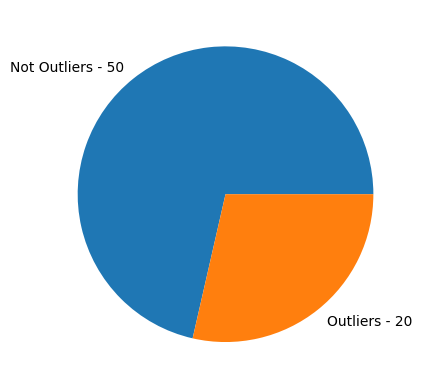

In [28]:
data.plot_outliers()

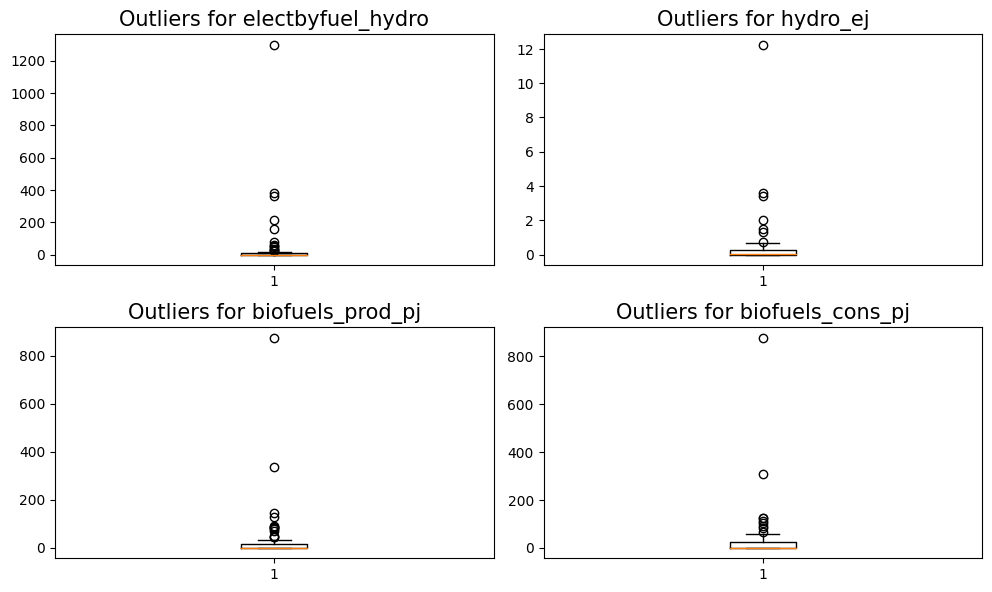

In [29]:
data.plot_outliers_for_col()

In [30]:
def scale(data):
    return data/max(data)

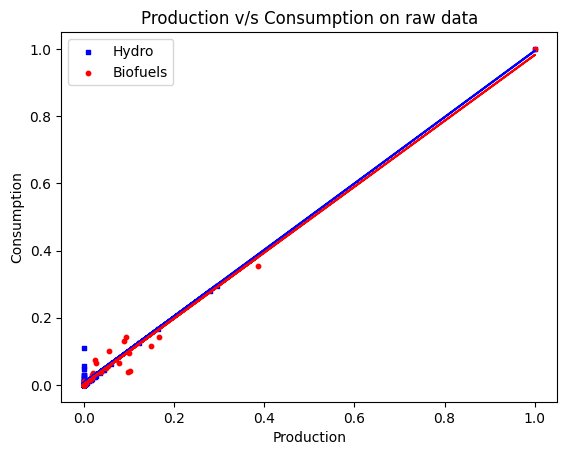

In [32]:
def compare(df, title):    
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    for col in ['electbyfuel_hydro', 'hydro_ej','biofuels_prod_pj', 'biofuels_cons_pj']:
        df[col] = scale(df[col])
        
    m1, b1 = np.polyfit(df['electbyfuel_hydro'], df['hydro_ej'], 1)
    m2, b2 = np.polyfit(df['biofuels_prod_pj'], df['biofuels_cons_pj'], 1)
    
    ax1.scatter(df['electbyfuel_hydro'], df['hydro_ej'], s=10, c='b', marker="s", label='Hydro')
    ax1.scatter(df['biofuels_prod_pj'], df['biofuels_cons_pj'], s=10, c='r', marker="o", label='Biofuels')
    ax1.plot(df['electbyfuel_hydro'], m1 * df['electbyfuel_hydro'] + b1, color = 'b')
    ax1.plot(df['biofuels_prod_pj'], m2 * df['biofuels_prod_pj'] + b2, color = 'r')
    
    plt.xlabel("Production")
    plt.ylabel("Consumption")
    plt.legend(loc='upper left')
    plt.title(title)
    plt.show()
    
compare(data.X.copy(), 'Production v/s Consumption on raw data')

20 outliers were detected


C:\Users\rlsha\AppData\Local\Temp\ipykernel_12916\2995335323.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = scale(df[col])


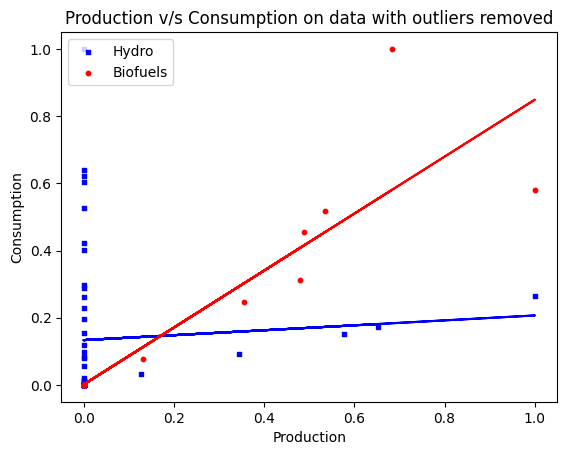

In [33]:
compare(data.remove_all_outliers(), 'Production v/s Consumption on data with outliers removed')